In [72]:
!pip install gymnasium


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np

UAV ENVIRONMENT

In [ ]:
class UAV_Env():
    def __init__(self, Users = 500,
                 size = 2000, #size area
                 UAV = 1,
                 v_UAV = 30,
                 UAV_coverage = 400,
                 max_steps = 50,
                 N_t = 300):
        self.Users = Users
        self.size = size
        self.UAV = UAV
        self.UAV_coverage = UAV_coverage
        self.max_steps = max_steps
        self.v_UAV = v_UAV
        self.N_t = N_t
        self.uav_location = np.zeros((2, self.UAV))
        self.users_location = np.random.normal(loc=self.size/2, scale=self.size/6, size=(2, self.Users))
        self.UAV_behavior = np.zeros((2, self.max_steps))
        self.step_ = 0 #count step

        self.observation_space = gym.spaces.Box(0, self.size, shape=(2, self.UAV), dtype=float)

        #5 actions, corresponding to "right", "up", "left", "down", "remain stationary"
        self.action_space = gym.spaces.Discrete(5)
        # Dictionary maps the abstract actions to the directions
        self._action_to_direction = {
            0: np.array([0, 0]),  # remain stationary
            1: np.array([0,self.v_UAV]),  # up
            2: np.array([-self.v_UAV, 0]),  # left
            3: np.array([0, -self.v_UAV]),  # down
            4: np.array([self.v_UAV, 0]),  # right
        }
        
    def step(self,action):
        tem = self.uav_location[:, 0] + self._action_to_direction[action]
        if 0 <= tem[0] <= self.size and 0 <= tem[1] <= self.size:  # restrict the UAVs' coordinates
          self.uav_location[:, 0] = tem
        #distance
        d_distance = np.zeros((1,self.Users))
        for n in range(self.Users):
          d_distance[0, n] = np.linalg.norm(self.users_location[:, n] - self.uav_location[:, 0], ord=2)
        connect_tem = np.zeros((1,self.Users))
        for n in range(self.Users):
           if d_distance[0,n] <= self.UAV_coverage:
              connect_tem[0,n] = 1
        total_connect = np.sum(connect_tem)
        if total_connect < self.N_t:
           reward = -1
        elif total_connect == self.N_t:
           reward = 0
        else:
           reward = 1
        
        self.step_ += 1

        done = self.step_ >= self.max_steps
        state = self.uav_location.copy()  # state 



        return state, reward, done
    def reset(self):
        self.uav_location = np.zeros((2, self.UAV))
        self.users_location = np.random.normal(loc=self.size/2, scale=self.size/6, size=(2, self.Users))
        self.UAV_behavior = np.zeros((2, self.max_steps))
        self.step_ = 0 #count step
        return self.uav_location.copy()



TEST UAV ENVIRONMENT

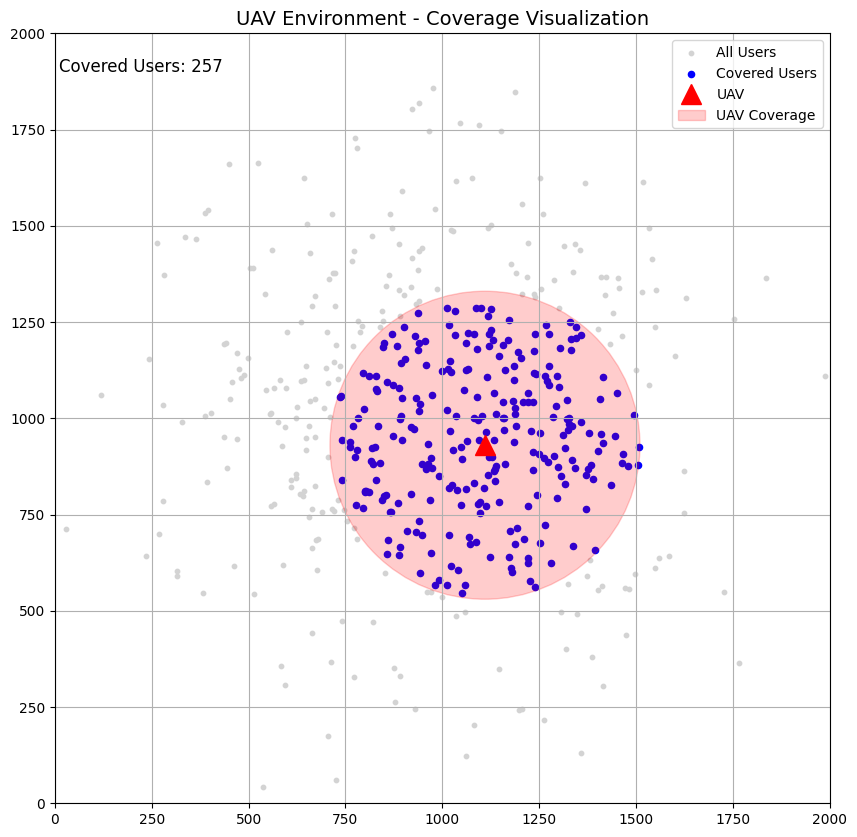

[996.38483361 997.70126238]


In [80]:
import matplotlib.pyplot as plt
import numpy as np

env = UAV_Env()

env.reset()

actions = [1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 4, 1, 1, 1, 4, 4, 4, 1, 1, 4, 1, 1, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]

for a in actions:
    env.step(a)

# Distance from UAV to each user
d_distance = np.zeros((1, env.Users))
for n in range(env.Users):
    d_distance[0, n] = np.linalg.norm(env.users_location[:, n] - env.uav_location[:, 0], ord=2)

# Count users within UAV coverage
connect_mask = d_distance[0] <= env.UAV_coverage

plt.figure(figsize=(10, 10))
plt.title("UAV Environment - Coverage Visualization", fontsize=14)
plt.xlim(0, env.size)
plt.ylim(0, env.size)

# Plot all users
plt.scatter(env.users_location[0], env.users_location[1], c='lightgray', label='All Users', s=10)

# Plot users within UAV coverage
plt.scatter(env.users_location[0, connect_mask], env.users_location[1, connect_mask], c='blue', label='Covered Users', s=20)

# Plot UAV
plt.plot(env.uav_location[0, 0], env.uav_location[1, 0], 'r^', markersize=15, label='UAV')

# Draw UAV coverage circle
circle = plt.Circle((env.uav_location[0, 0], env.uav_location[1, 0]), env.UAV_coverage, color='r', alpha=0.2, label='UAV Coverage')
plt.gca().add_patch(circle)

# Annotate number of covered users
covered_count = np.sum(connect_mask)
plt.text(10, env.size - 100, f'Covered Users: {covered_count}', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

# Print mean of user locations
print(np.mean(env.users_location, axis=1))
